In [1]:
import nengo 
import numpy as np
from nengo.dists import Uniform
import matplotlib.pyplot as plt

In [2]:
T = 1
min_fr = 90 
max_fr = 150
mu = 0
o_att = 1.00
stim = [0.5, 0, 0.5]
stim_pos = [-0.5, 0, 0.5]
t_rc = 0.02 #0.02
t_ref = 0.002

RMSES_col1 = []
RMSES_col2 = []
RMSES_col3 = []

for i in range(10):
    model = nengo.Network()
    lif_model = nengo.LIF(tau_rc=t_rc, tau_ref=t_ref)
    with model:
        visual_stim = nengo.Node(stim)
        positions = nengo.Node(stim_pos)
        v1_column1 = nengo.Ensemble(n_neurons=200, dimensions=1, radius=1, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)
        v1_column2 = nengo.Ensemble(n_neurons=200, dimensions=1, radius=1, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)
        v1_column3 = nengo.Ensemble(n_neurons=200, dimensions=1, radius=1, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)
        nengo.Connection(positions[0], v1_column1)
        nengo.Connection(positions[1], v1_column2)
        nengo.Connection(positions[2], v1_column3)

        controls = nengo.Node([mu, o_att])
        control_neurons = nengo.Ensemble(n_neurons=400, dimensions=2, radius=2, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)
        nengo.Connection(controls, control_neurons)

        routing_guide1 = nengo.Ensemble(n_neurons=600, dimensions=3, radius=2, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)
        routing_guide2 = nengo.Ensemble(n_neurons=600, dimensions=3, radius=2, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)
        routing_guide3 = nengo.Ensemble(n_neurons=600, dimensions=3, radius=2, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)

        nengo.Connection(v1_column1, routing_guide1[0])
        nengo.Connection(v1_column2, routing_guide2[0])
        nengo.Connection(v1_column3, routing_guide3[0])
        nengo.Connection(control_neurons, routing_guide1[1:])
        nengo.Connection(control_neurons, routing_guide2[1:])
        nengo.Connection(control_neurons, routing_guide3[1:])

        feedforward1 = nengo.Ensemble(n_neurons=600, dimensions=2, radius=2, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)
        feedforward2 = nengo.Ensemble(n_neurons=600, dimensions=2, radius=2, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)
        feedforward3 = nengo.Ensemble(n_neurons=600, dimensions=2, radius=2, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)

        def gating_func(x):
            pos = x[0]
            center = x[1]
            width = x[2]
            if pos > center + width or pos < center - width:
                return 0
            else:
                return 1

        nengo.Connection(visual_stim[0], feedforward1[1])
        nengo.Connection(visual_stim[1], feedforward2[1])
        nengo.Connection(visual_stim[2], feedforward3[1])
        nengo.Connection(routing_guide1, feedforward1[0], function=gating_func)
        nengo.Connection(routing_guide2, feedforward2[0], function=gating_func)
        nengo.Connection(routing_guide3, feedforward3[0], function=gating_func)

        gating1 = nengo.Ensemble(n_neurons=300, dimensions=1, radius=2, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)
        gating2 = nengo.Ensemble(n_neurons=300, dimensions=1, radius=2, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)
        gating3 = nengo.Ensemble(n_neurons=300, dimensions=1, radius=2, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)

        def MT_column_func(x):
            gating = x[0]
            stim = x[1]
            if gating > 0.5:
                return stim
            else:
                return 0

        nengo.Connection(feedforward1, gating1, function=MT_column_func)
        nengo.Connection(feedforward2, gating2, function=MT_column_func)
        nengo.Connection(feedforward3, gating3, function=MT_column_func)

        combined1 = nengo.Ensemble(n_neurons=900, dimensions=4, radius=2, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)
        combined2 = nengo.Ensemble(n_neurons=900, dimensions=4, radius=2, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)
        combined3 = nengo.Ensemble(n_neurons=900, dimensions=4, radius=2, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)

        nengo.Connection(gating1, combined1[0])
        nengo.Connection(routing_guide1, combined1[1:])
        nengo.Connection(gating2, combined2[0])
        nengo.Connection(routing_guide2, combined2[1:])
        nengo.Connection(gating3, combined3[0])
        nengo.Connection(routing_guide3, combined3[1:])

        MT_column1 = nengo.Ensemble(n_neurons=300, dimensions=1, radius=1, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)
        MT_column2 = nengo.Ensemble(n_neurons=300, dimensions=1, radius=1, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)
        MT_column3 = nengo.Ensemble(n_neurons=300, dimensions=1, radius=1, max_rates=Uniform(min_fr,max_fr),neuron_type=lif_model)
        
        def strength_func1(x):
            stim = x[0]
            pos = -0.5
            center = x[2]
            width = x[3]
            diff = (center-pos)
            f = np.exp(-(diff)**2/(2*width**2))
            return stim*f

        def strength_func2(x):
            stim = x[0]
            pos = 0
            center = x[2]
            width = x[3]
            diff = (center-pos)
            f = np.exp(-(diff)**2/(2*width**2))
            return stim*f

        def strength_func3(x):
            stim = x[0]
            pos = 0.5
            center = x[2]
            width = x[3]
            diff = (center-pos)
            f = np.exp(-(diff)**2/(2*width**2))
            return stim*f

        nengo.Connection(combined1, MT_column1, function=strength_func1)
        nengo.Connection(combined2, MT_column1, function=strength_func1)
        nengo.Connection(combined3, MT_column1, function=strength_func1)

        nengo.Connection(combined1, MT_column2, function=strength_func2)
        nengo.Connection(combined2, MT_column2, function=strength_func2)
        nengo.Connection(combined3, MT_column2, function=strength_func2)

        nengo.Connection(combined1, MT_column3, function=strength_func3)
        nengo.Connection(combined2, MT_column3, function=strength_func3)
        nengo.Connection(combined3, MT_column3, function=strength_func3)

        probe_1 = nengo.Probe(MT_column1,synapse=0.01)
        probe_2 = nengo.Probe(MT_column2,synapse=0.01)
        probe_3 = nengo.Probe(MT_column3,synapse=0.01)

    sim = nengo.Simulator(model)
    sim.run(T)
    t = sim.trange()
    stim_in = np.full(len(t),0.5)
    RMSES_col1.append(np.sqrt(np.average((stim_in-sim.data[probe_1])**2)))
    RMSES_col2.append(np.sqrt(np.average((stim_in-sim.data[probe_2])**2)))
    RMSES_col3.append(np.sqrt(np.average((stim_in-sim.data[probe_3])**2)))

#mt1_res = np.full(len(t),stim[0]*np.exp(-(mu-(-0.5))**2/(2*o_att**2)) + stim[1]*np.exp(-(mu-(-0.5))**2/(2*o_att**2)) + stim[2]*np.exp(-(mu-(-0.5))**2/(2*o_att**2)))
#mt2_res = np.full(len(t),stim[0]*np.exp(-(mu-(0))**2/(2*o_att**2)) + stim[1]*np.exp(-(mu-(0))**2/(2*o_att**2)) + stim[2]*np.exp(-(mu-(0))**2/(2*o_att**2)))
#mt3_res = np.full(len(t),stim[0]*np.exp(-(mu-(0.5))**2/(2*o_att**2)) + stim[1]*np.exp(-(mu-(0.5))**2/(2*o_att**2)) + stim[2]*np.exp(-(mu-(0.5))**2/(2*o_att**2)))

[#########################         Building... 30%                                   ] ETA: 0:00:01

/Users/lindawang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in double_scalars
/Users/lindawang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in double_scalars
/Users/lindawang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in double_scalars


Building finished in 0:00:03.                                                                        
Simulating finished in 0:00:03.                                                                      
Building finished in 0:00:03.                                                                        
Simulating finished in 0:00:03.                                                                      
Building finished in 0:00:03.                                                                        
Simulating finished in 0:00:03.                                                                      
Building finished in 0:00:02.                                                                        
Simulating finished in 0:00:02.                                                                      
Building finished in 0:00:02.                                                                        
Simulating finished in 0:00:02.                                                   

In [3]:
RMSES_col1 = np.array(RMSES_col1)
RMSES_col2 = np.array(RMSES_col2)
RMSES_col3 = np.array(RMSES_col3)
print('For column 1')
print('Average RMSE: %g' % np.average(RMSES_col1))
print('Min: %g' % np.amin(RMSES_col1))
print('Max: %g' % np.amax(RMSES_col1))
print('Std dev: %g' % np.std(RMSES_col1))
print('For column 2')
print('Average RMSE: %g' % np.average(RMSES_col2))
print('Min: %g' % np.amin(RMSES_col2))
print('Max: %g' % np.amax(RMSES_col2))
print('Std dev: %g' % np.std(RMSES_col2))
print('For column 3')
print('Average RMSE: %g' % np.average(RMSES_col3))
print('Min: %g' % np.amin(RMSES_col3))
print('Max: %g' % np.amax(RMSES_col3))
print('Std dev: %g' % np.std(RMSES_col3))

For column 1
Average RMSE: 0.230447
Min: 0.176116
Max: 0.291067
Std dev: 0.0377947
For column 2
Average RMSE: 0.322718
Min: 0.249429
Max: 0.415941
Std dev: 0.0449662
For column 3
Average RMSE: 0.250265
Min: 0.20262
Max: 0.330088
Std dev: 0.0321684


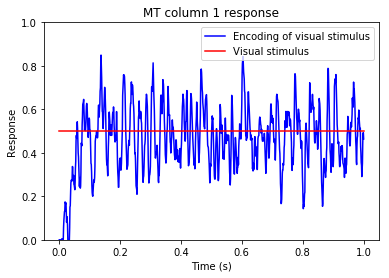

RMSE 0.159579


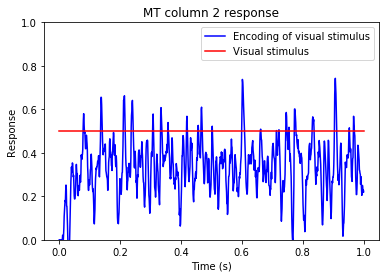

RMSE 0.212773


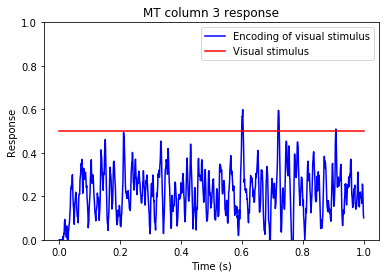

RMSE 0.301531


In [85]:
plt.figure()
plt.title('MT column 1 response')
plt.plot(t, sim.data[probe_1],'b',label='Encoding of visual stimulus')
plt.plot(t, stim_in, 'r', label='Visual stimulus')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.ylim(0,1)
plt.legend()
plt.show()
print('RMSE %g' % np.sqrt(np.average((stim_in-sim.data[probe_1])**2)))

plt.figure()
plt.title('MT column 2 response')
plt.plot(t, sim.data[probe_2],'b',label='Encoding of visual stimulus')
plt.plot(t, stim_in, 'r', label='Visual stimulus')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.ylim(0,1)
plt.legend()
plt.show()
print('RMSE %g' % np.sqrt(np.average((stim_in-sim.data[probe_2])**2)))

plt.figure()
plt.title('MT column 3 response')
plt.plot(t, sim.data[probe_3],'b',label='Encoding of visual stimulus')
plt.plot(t, stim_in, 'r', label='Visual stimulus')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.ylim(0,1)
plt.legend()
plt.show()
print('RMSE %g' % np.sqrt(np.average((stim_in-sim.data[probe_3])**2)))